In [ ]:
!pip install transformers


In [ ]:
#install hugging face evaluate 
!pip install evaluate

In [31]:
# imports 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from transformers import pipeline

#from datasets import load_dataset
from transformers import TrainingArguments, Trainer
from huggingface_hub import notebook_login
from textwrap import wrap


import evaluate

from sklearn.metrics import roc_curve, auc


from sklearn.metrics import confusion_matrix, classification_report  


In [4]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')
     

Mounted at /content/drive


In [7]:
# Read Data

# English trainset/valset 
eng_trainset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_csv/train_seg.csv") 
eng_valset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_csv/val_seg.csv") 

# German trainset/valset 
ger_trainset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /ger_trainset.csv") 
ger_valset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /ger_valset.csv") 

# French trainset/valset 
fr_trainset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /train_french.csv") 
fr_valset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /val_french.csv") 

# Dutch trainset/valset 

nl_trainset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /train_dutch.csv") 
nl_valset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /val_dutch.csv") 

In [ ]:
ger_valset

,messages_de,label
0,"['Ich habe gerade gesagt: ""eine riesige Versäu...",0
1,"['Hallo', '15 m', '13 f', 'Hey', 'hey', 'Wie g...",0
2,['smartbhai: Niemand kann helfen.. wenn wir ni...,0
3,"['hei', 'hey', 'Asl?', '15 f Fin :)', 'u?', '1...",0
4,"['hey hast du mein Emial bekommen', 'nicht gep...",1
...,...,...
1313,"['Heya', 'Bonersauraus Rex', 'Hallo', 'mein ti...",0
1314,"['Hallo', 'Hallo.', 'wie sind Sie fremd?', 'Ic...",0
1315,"['Hey!', 'Hallo!', 'f/m', 'f', 'Du?', 'ok', 'm...",0
1316,"['weiblich? ich hoffe, dass niemand spricht', ...",0


In [5]:
#English test set 
eng_testset=pd.read_csv('/content/drive/MyDrive/IM/VTPAN_csv/VTPAN-test.csv')

#German test set 
ger_testset=pd.read_csv('/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /ger_testset.csv')

#French test set 
#fr_testset= pd.read_csv('/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /test_french.csv')

#Dutch test set 
#nl_testset=pd.read_csv('/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /test_dutch.csv')

In [ ]:
ger_testset

,id,isCybergrooming,authors,messages,messages_de,label
0,de15188e9fd515ed817a0b34546be902,True,"[{'id': 'b6fe182274453b707870b16e5d2ad562', 'i...",[{'author': 'b6fe182274453b707870b16e5d2ad562'...,"['Rückseite', 'ok baby', 'was passiert Baby', ...",1
1,17784c5a093477c1706b1a68cea7c802,False,"[{'id': 'fcfda042c76436b97eca32b6c0490d1d', 'i...",[{'author': '713349f3afa2dbe352d2abe4d3f01a12'...,"['Hallo', 'Jungs sind Scheiß', 'dass sie', 'Ha...",0
2,15a38614944f5aa8bbb59d4153ecc12a,False,"[{'id': '454addae11c0b90c0f36a98b77aa07a6', 'i...",[{'author': 'ee792e8acb278ddd16cc46020c694b0b'...,"['Hallo', '19 m USA horny, u?', '2+2*2', '2+2*...",0
3,ee0aba2365c16a30cb36d1057a390b16,False,"[{'id': '471970f323f46dc39b5f07c6aa344686', 'i...",[{'author': 'bb2a120ae4ec93ef7c15f284b9b46544'...,"['f/m?', 'Hallo', 'da', 'f', 'u?', 'Hallo', 'm...",0
4,ca1b963746e368a4cec38ab4be3fdcf7,False,"[{'id': 'ed6658e6f22583ed66fb5e5e735b9e63', 'i...",[{'author': 'ed6658e6f22583ed66fb5e5e735b9e63'...,"['tut mir leid, ich bin jetzt wieder.', 'und f...",0
...,...,...,...,...,...,...
15324,85e044706ceca109b1adf6c744a4126c,False,"[{'id': 'f8eb7d3ae7f27896e571109636a043e0', 'i...",[{'author': 'f8eb7d3ae7f27896e571109636a043e0'...,"['Hallo', 'Hallo', 'Hey...', 'gut, das ist sel...",0
15325,ec391a65097a955029afaedc23d5fa81,True,"[{'id': '2e0d170f2addfb0048f9424a2daa5a73', 'i...",[{'author': '2e0d170f2addfb0048f9424a2daa5a73'...,"['Hallo', 'Asl?', 'heya was ist?', '13/f/socal...",1
15326,82add2c9da3c267a98b3981375b6c238,True,"[{'id': 'c5502c7c9bb5e28508a3e19ec869f6d2', 'i...",[{'author': 'c5502c7c9bb5e28508a3e19ec869f6d2'...,"['Guten Morgen, wie R U?', 'hey :)', 'Ich bin ...",1
15327,e2bc24141a2855dd6825d8b3132bfa11,False,"[{'id': 'e46825dc4ec1ff89f6bb078ce5589357', 'i...",[{'author': 'bced152c52f046adc88110ad1e8b3e83'...,"['Hallo', 'm oder f', 'Hallo', 'f', '& u', ':)...",0


# **Prepare Data**

In [8]:
#rename cols in training data 
eng_trainset.rename(columns = {'segment':'messages'}, inplace = True)
ger_trainset.rename(columns = {'messages_de':'messages'}, inplace = True)
fr_trainset.rename(columns = {'messages_fr':'messages'}, inplace = True)
nl_trainset.rename(columns = {'messages_dutch':'messages'}, inplace = True)

#rename cols in val data  

eng_valset.rename(columns = {'segment':'messages'}, inplace = True)
ger_valset.rename(columns =  {'messages_de':'messages'}, inplace = True)
fr_valset.rename(columns = {'messages_fr':'messages'}, inplace = True)
nl_valset.rename(columns = {'messages_dutch':'messages'}, inplace = True)

In [ ]:
eng_valset

,messages,label
0,mornin :) hello just opened my eyes n u were u...,1
1,hi asl? :/ :\ :/ :\ im eating ? younger then 1...,0
2,hi m/f? hi f male here. age? 17 ok im 20. wher...,0
3,befddef7b56a6caf71fa21f2235a8111: pong hi i no...,0
4,ever been dumped? hii awww yea i have haha did...,0
...,...,...
1972,ey :p hi Do you know Jesus Christ as your savi...,0
1973,because you're sounding a little like m e haha...,0
1974,hey hello :) how's it going? pretty good and y...,0
1975,hi hi how are you? asl? fine 14 female u? you?...,0


In [9]:
#concatenate all train
dfs_t = [eng_trainset, ger_trainset, fr_trainset, nl_trainset]

all_lang_train = pd.concat(dfs_t)

In [10]:
#concatenate all val datsets 

dfs_v = [eng_valset, ger_valset, fr_valset, nl_valset]

all_lang_val = pd.concat(dfs_v)

In [11]:
all_lang_val

,messages,label
0,mornin :) hello just opened my eyes n u were u...,1
1,hi asl? :/ :\ :/ :\ im eating ? younger then 1...,0
2,hi m/f? hi f male here. age? 17 ok im 20. wher...,0
3,befddef7b56a6caf71fa21f2235a8111: pong hi i no...,0
4,ever been dumped? hii awww yea i have haha did...,0
...,...,...
1313,"['Heya.', 'bonersauraus Rex', 'Hallo.', 'Mijn ...",0
1314,"['Hallo.', 'Hallo.', 'Hoe ben je vreemd?', 'Ik...",0
1315,"['Hey!', 'Hallo!', 'f/m', 'f.', 'Jij?', 'Oké.'...",0
1316,"['Vrouw? Ik hoop dat niemand praat.', 'Hallo.'...",0


In [ ]:
#save concat datasets 
all_lang_train.to_csv('trainset_all', index=False)
all_lang_val.to_csv('valset_all', index=False)


In [39]:
trainset= pd.read_csv('/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /trainset_all') 
valset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /valset_all") 

In [40]:
trainset

,messages,label
0,[http://twitter.com/Seoworkers] Google recomme...,0
1,heeeyyyyyyy heyy asl? ahhhhhh your just gonna ...,0
2,Would you like to become one with mother Russi...,0
3,hey Aimee hi how r u tonight? alright I guess ...,1
4,Hi:) i am a genie and i will grant you one wis...,0
...,...,...
20416,"['Hallo.', 'heb een tool nodig om unix/samba-a...",0
20417,"['Wat doe je liefje?', 'We zoeken dingen op.',...",1
20418,"['Haï', 'asl.', 'Hey :D', 'haha omg.. quicky.'...",0
20419,"['hiii asl?', 'Hallo.', 'm', 'Im 15 f.', 'Im 1...",0


In [41]:
#Shuffle datasets 

from sklearn.utils import shuffle
trainset = shuffle(trainset)
valset = shuffle(valset)

In [43]:
trainset

,messages,label
7244,['hallo kan iemND mich traf meine hardeschijf ...,0
6205,"['hey ich bin wieder fertig mit den Spielen', ...",1
20231,['Wat betekent het om dit zogenaamde CSSOM te ...,0
13516,"['ok je suis de retour', 'Hey sorry I went to ...",1
1846,hey hi asl? asl? :) u first :) 17 m brazil u? ...,0
...,...,...
16496,['ef6f2287bae00ba79475fbf56c2b6fee: we nemen z...,0
4379,Hey hey hi what ya doin? How was supper good h...,1
19478,"['u daar.', ':)', 'Ja.', 'ohhhhhhhhh', 'Im inv...",1
758,i like namecheap.com my company buys 30+ domai...,0


In [28]:
class_names = [ 'non predator', 'predator']
     

In [13]:
#one-hot encoding the labels 
def to_sentiment(label):
  if label == 'predator':
    return 1
  elif label == 'non-predator':
    return 0

eng_testset['label'] = eng_testset['label'].apply(to_sentiment)

In [ ]:
eng_testset

,label,chatName,segment
0,1,de15188e9fd515ed817a0b34546be902,back ok babe what happend babe dog wanted out ...
1,0,17784c5a093477c1706b1a68cea7c802,hello boys are shit that they are hi sorry i w...
2,0,15a38614944f5aa8bbb59d4153ecc12a,"hi 19 m usa horny, u? 2+2*2 2+2*2? 6? yay now ..."
3,0,ee0aba2365c16a30cb36d1057a390b16,f/m ? hi there f u? hi m 18 nice ireland u ? u...
4,0,ca1b963746e368a4cec38ab4be3fdcf7,"sorry, I'm back now. and for the record I want..."
...,...,...,...
15324,0,85e044706ceca109b1adf6c744a4126c,Hello hello Hey... well this is awkward Really...
15325,1,ec391a65097a955029afaedc23d5fa81,hi asl? heya whats up? 13/f/socal whats ur asl...
15326,1,82add2c9da3c267a98b3981375b6c238,"good morning , how r u? hey :) im good u? am o..."
15327,0,e2bc24141a2855dd6825d8b3132bfa11,hi m or f hi f & u :) M :) frm? You ok ya im f...


# **Model**

In [14]:
#load model 
model= AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base")

tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [15]:
#all languages dataset to list
X_train = list(trainset["messages"])
y_train = list(trainset["label"])
X_val = list(valset["messages"])
y_val = list(valset["label"])
   

In [9]:
# german data to list
#X_train_ger = list(ger_trainset["messages_de"])
#y_train_ger = list(ger_trainset["label"])
#X_val_ger = list(ger_valset["messages_de"])
#y_val_ger = list(ger_valset["label"])
   

In [16]:
#English testset
X_test_eng = list(eng_testset["segment"])
y_test_eng = list(eng_testset["label"])

#German testset
X_test_ger = list(ger_testset["messages_de"])
y_test_ger = list(ger_testset["label"])

#French testset
##X_test_fr = list(fr_testset["messages_de"])
##y_test_fr = list(fr_testset["label"])

#Dutch tesset 
##X_test_nl = list(nl_testset["messages_de"])
##y_test_nl = list(nl_testset["label"])

In [17]:
#tokenize train/val data 
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=512)


In [18]:
#tokenize test data for 4 languages 

test_encodings_eng = tokenizer(X_test_eng, truncation=True, padding=True, max_length=512)
test_encodings_ger = tokenizer(X_test_ger, truncation=True, padding=True, max_length=512)
#test_encodings_fr = tokenizer(X_test_fr, truncation=True, padding=True, max_length=512)
#test_encodings_nl = tokenizer(X_test_nl, truncation=True, padding=True, max_length=512)

In [19]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])
     

In [20]:
#load the train/val datase
train_dataset = Dataset(train_encodings, y_train)
val_dataset = Dataset(val_encodings, y_val)




In [21]:
#load english/german testsets 
test_dataset_eng = Dataset(test_encodings_eng, y_test_eng)
test_dataset_ger = Dataset(test_encodings_ger, y_test_ger)

# **Model training on all languages**

In [22]:
# Define Trainer
args = TrainingArguments(
    output_dir="xmlRoberta_allLang",
    num_train_epochs=3,
    per_device_train_batch_size=16

)
trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset)

In [23]:
#train
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.378200
1000,0.382200
1500,0.367200
2000,0.382800
2500,0.372100
3000,0.377500
3500,0.366500


TrainOutput(global_step=3831, training_loss=0.3752037631846134, metrics={'train_runtime': 5846.8703, 'train_samples_per_second': 10.478, 'train_steps_per_second': 0.655, 'total_flos': 1.611897258451968e+16, 'train_loss': 0.3752037631846134, 'epoch': 3.0})

In [19]:
notebook_login()


Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
#push model to hub
trainer.push_to_hub()

# **Testing XML-Roberta on each language seperately**

**Testing on German**

In [25]:
#get prediction from German test data 
predictions = trainer.predict(test_dataset_ger)
preds_ger = np.argmax(predictions.predictions, axis=-1)
     

In [26]:
# macro f1 on test German data 
metric = evaluate.load("f1")
metric.compute(predictions=preds_ger, references=y_test_ger,  average="macro")
     

{'f1': 0.47489038092628116}

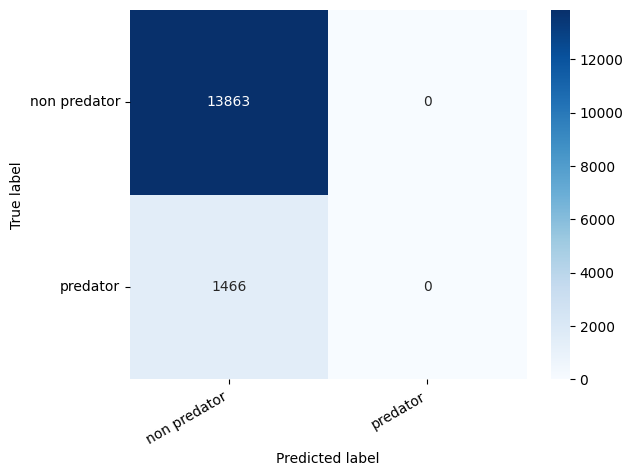

In [29]:
#confusion matrix 
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label');
cm = confusion_matrix(y_test_ger, preds_ger)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

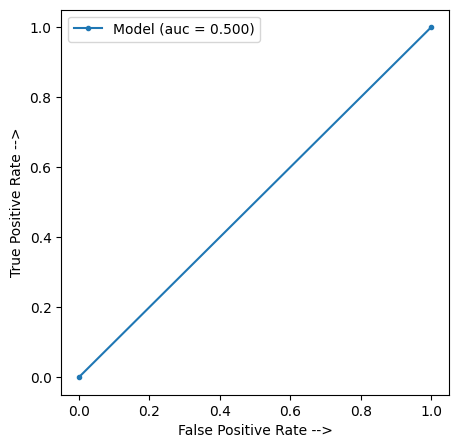

In [32]:
fpr, tpr, threshold = roc_curve(y_test_ger, preds_ger)
auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr, tpr, marker='.', label='Model (auc = %0.3f)' % auc)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

In [33]:
#missclassified examples 
misclassified = np.where(preds_ger != y_test_ger)
print(misclassified)

(array([    0,    16,    24, ..., 15300, 15325, 15326]),)


In [34]:
#example from the test data and its true and predicted labels
idx = 1827
review_text = ger_testset['messages_de'][idx]
true_sentiment = y_test_ger[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': preds_ger[idx]
}) 
print("\n".join(wrap(review_text)))
print()
print(f'True label: {class_names[true_sentiment]}')
print()
print(f'Predicted label: {preds_ger[idx]}')


['Asl', '13 f Süd-Portland u?', 'Hallo', 'wie ältere Jungs?', 'hell
yea', '21m', 'kühle', 'Bild?', 'auf meinem Profi', 'ich habe 1', 'sehr
niedlich', 'Reale', 'ja', 'zugleich', 'du hast ein Bild', 'Ja', 'mit
mir verbinden', 'huh', 'Klicken Sie auf den Botton, der Fotos abgibt',
'an der Spitze', 'es wird nicht funktionieren', 'E-Mail es', 'was ist
Ihre E-Mail', 'Das ist nicht alles, was ich tun kann.', 'k h/o', 'kk',
'Gesandt', 'kk', 'habe es gehängt', 'omg ur niedlich', 'alsx', 'wo du
lebst', 'Scarborough', 'ist das nahe mir?', 'wo du lebst', 'Süd-
Portland', 'nächste Stadt', 'ich habe mich gerade hier im November
verlegt', 'von wo', 'Michigan', 'o kühle', 'wha u wie 2 tun für Spaß',
'Verweilen', 'u?', 'Party lol', 'haha', 'weitere Bilder von Ihnen',
'ja lol', 'Können Sie mir einige senden', 'kk hängen auf',
'Bearbeiten', 'nichts da', 'kk lassen Sie mich es per E-Mail', 'wha ur
ibiil', 'ich habe dir gerade emailed', 'einfach darauf antworten',
'kk', "grrrrr ich hav 2 verwenden meine an

**Testing on English**

In [ ]:
#get prediction from English test data 
#predictions = trainer.predict(test_dataset_eng)
#preds_eng = np.argmax(predictions.predictions, axis=-1)

In [ ]:
# macro f1 on test English data 
##metric = evaluate.load("f1")
##metric.compute(predictions=preds_eng, references=y_test_eng,  average="macro")

In [31]:
#classification report

print(classification_report(y_test_eng, preds_eng, target_names=class_names))

              precision    recall  f1-score   support

non predator       0.99      0.99      0.99     13863
    predator       0.90      0.91      0.90      1466

    accuracy                           0.98     15329
   macro avg       0.94      0.95      0.95     15329
weighted avg       0.98      0.98      0.98     15329



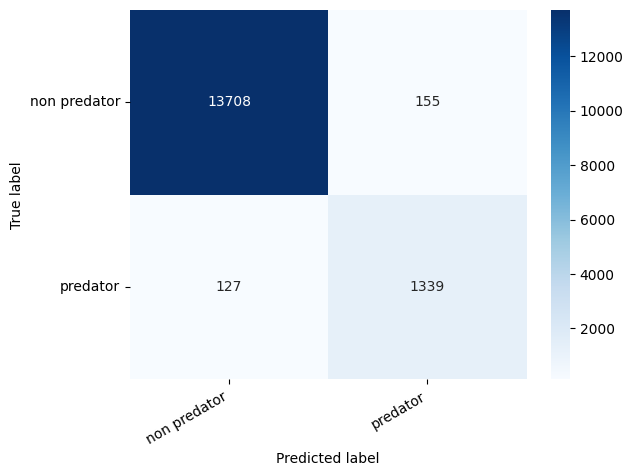

In [32]:
#confusion matrix 
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label');
cm = confusion_matrix(y_test_eng, preds_eng)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)
     

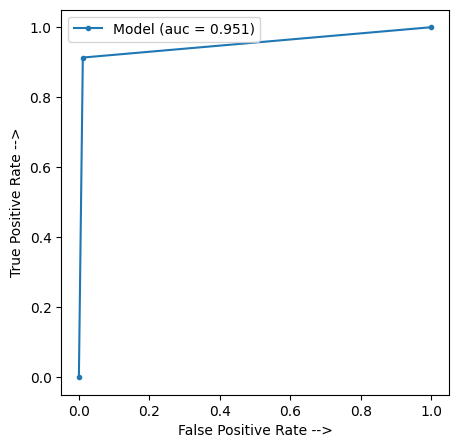

In [26]:
#AUC
fpr, tpr, threshold = roc_curve(y_test_eng, preds_eng)
auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr, tpr, marker='.', label='Model (auc = %0.3f)' % auc)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()


In [27]:
#missclassified examples 
misclassified = np.where(preds_ger != y_test_ger)
print(misclassified)

(array([    1,    11,    30,    41,    89,   157,   245,   358,   374,
         499,   548,   858,   863,   929,   962,   983,   984,  1051,
        1074,  1115,  1259,  1514,  1532,  1535,  1609,  1664,  1723,
        1770,  1801,  1827,  1979,  2005,  2021,  2041,  2065,  2151,
        2185,  2198,  2221,  2389,  2424,  2454,  2456,  2576,  2702,
        2791,  2793,  2821,  2835,  2856,  3064,  3204,  3222,  3428,
        3434,  3522,  3616,  3754,  3779,  3809,  3943,  3947,  3959,
        4037,  4063,  4111,  4127,  4194,  4304,  4426,  4429,  4468,
        4479,  4483,  4515,  4535,  4550,  4604,  4656,  4658,  4692,
        4701,  4849,  4908,  4971,  5079,  5102,  5201,  5262,  5352,
        5371,  5391,  5429,  5434,  5526,  5535,  5568,  5574,  5633,
        5658,  5666,  5762,  5835,  5902,  5910,  5941,  5956,  6027,
        6136,  6173,  6182,  6289,  6372,  6418,  6419,  6459,  6519,
        6599,  6846,  6850,  6952,  6972,  7080,  7106,  7137,  7210,
        7372,  7381

In [70]:
#example from the test data and its true and predicted labels
idx = 1827
review_text = ger_testset['messages_de'][idx]
true_sentiment = y_test_ger[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': preds_ger[idx]
}) 
print("\n".join(wrap(review_text)))
print()
print(f'True label: {class_names[true_sentiment]}')
print()
print(f'Predicted label: {preds_ger[idx]}')


['Asl', '13 f Süd-Portland u?', 'Hallo', 'wie ältere Jungs?', 'hell
yea', '21m', 'kühle', 'Bild?', 'auf meinem Profi', 'ich habe 1', 'sehr
niedlich', 'Reale', 'ja', 'zugleich', 'du hast ein Bild', 'Ja', 'mit
mir verbinden', 'huh', 'Klicken Sie auf den Botton, der Fotos abgibt',
'an der Spitze', 'es wird nicht funktionieren', 'E-Mail es', 'was ist
Ihre E-Mail', 'Das ist nicht alles, was ich tun kann.', 'k h/o', 'kk',
'Gesandt', 'kk', 'habe es gehängt', 'omg ur niedlich', 'alsx', 'wo du
lebst', 'Scarborough', 'ist das nahe mir?', 'wo du lebst', 'Süd-
Portland', 'nächste Stadt', 'ich habe mich gerade hier im November
verlegt', 'von wo', 'Michigan', 'o kühle', 'wha u wie 2 tun für Spaß',
'Verweilen', 'u?', 'Party lol', 'haha', 'weitere Bilder von Ihnen',
'ja lol', 'Können Sie mir einige senden', 'kk hängen auf',
'Bearbeiten', 'nichts da', 'kk lassen Sie mich es per E-Mail', 'wha ur
ibiil', 'ich habe dir gerade emailed', 'einfach darauf antworten',
'kk', "grrrrr ich hav 2 verwenden meine an

In [ ]:
len(preds_ger)

15329

In [ ]:
#example from the test data and its true and predicted labels
idx = 729
review_text = ger_testset['messages_de'][idx]
true_sentiment = y_test_ger[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': preds_ger[idx]
}) 
print("\n".join(wrap(review_text)))
print()
print(f'True label: {class_names[true_sentiment]}')
print()
print(f'Predicted label: {preds_ger[idx]}')


['hiiii', 'hey', 'wie bist du', 'u horny', 'Gutes', 'Nein', 'Gutes',
'was ist ur asl', 'jeder ist lol', 'lol I kno', '18/f/ny', 'oh cool',
'ich kam hier für Rat kann du helfen', 'sicher', 'ok ich brauche
jemanden, um mir etwas herauszufinden', 'ok', 'es geht um meinen
Bruder', 'ok', 'etwas geschah und es ist wirklich seltsam, wenn das ok
ist', 'ja', 'Ich weiß nicht so viel über Jungs, aber ich kann dir
sagen, was passiert ist', 'ok', 'im 14 also habe ich noch keine bf',
'ok', 'ok so hier ist was passiert ist', 'ok', 'meine Mutter und ich
schauten Fernsehen und mein Bruder kam in er ist 16', 'ok', 'so kam er
hinein und sagte, dass er schmerzte und meine Mutter war wie wo und er
würde nicht sagen', 'dann zeigte er schließlich wie auf seine Müll',
'so sagte mir meine Mutter, zum Bett zu gehen', 'ok', 'so beobachtete
ich aus dem anderen Raum, weil ich wie wtf war', 'ok, das würde ich
tun', 'meine Mutter sagte ihm, sie würden ins Krankenhaus gehen und er
war wie zu weinen und zu sagen, nein

In [ ]:

#example from the test data and its true and predicted labels
idx = 157
review_text = ger_testset['messages_de'][idx]
true_sentiment = y_test_ger[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': preds_ger[idx]
}) 
print("\n".join(wrap(review_text)))
print()
print(f'True label: {class_names[true_sentiment]}')
print()
print(f'Predicted label: {preds_ger[idx]}')

     

['Hallo da', 'Hallo', 'Asl', '40 Lansing', 'Sie', 'Oh', '14 f se mi',
'k', 'ur kinda Schnitt aussehen', 'niedlich*', 'zugleich', 'Sie haben
ein Bild?', 'Myspace', 'Links auf meinem yaho Profil', 'tut mir leid
falsch Fenster', 'hm?', 'wenn du nicht wünschst du sage so k', 'Lass
mich nicht so hängen', 'ich habe das falsche im Fenster eingegeben',
'kümmern sich um Jungs auf Cam zu sehen?', "Don 't Mattr zu mir", 'du
bist da oder willst du nicht mit mir reden?']

True label: predator

Predicted label: 0


In [ ]:
#example from the test data and its true and predicted labels
idx = 150
review_text = ger_testset['messages_de'][idx]
true_sentiment = y_test_ger[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': preds_ger[idx]
}) 
print("\n".join(wrap(review_text)))
print()
print(f'True label: {class_names[true_sentiment]}')
print()
print(f'Predicted label: {preds_ger[idx]}')


['hey', 'wie ist meine sexy kleine Schlampe?', 'Gutes', 'hpw r u',
'horny', 'hehe u immer r', 'Ich wünschte, ich könnte dich jetzt in den
Arsch ficken', 'hehe', 'wollen Bilder mit dir in Rocks mit meinem
Sperma aus deinen Löchern laufen machen', 'ob ich?', 'ja', 'würden Sie
das gerne?', 'ja', 'Tropfen aus deiner Muschi und Arsch?', 'hehe ja',
'Fingern beide Löcher nach in den Bildern zu, dann licken sie sauber',
'ur so ein schlechter Junge :D', 'Sie würden das gerne in Bildern und
auf Film machen', 'wit u i woudl', 'hast du jemals deinen Arsch
gefingert?', 'Ich habe am anderen Abend ein Lil getan, als du mir
gesagt hast', 'es war ein bisschen gut', 'hast du nass?', 'ein Lil',
'glaubst du, du könntest von ihm cum?', 'Nah', 'u beschäftigt', 'nein.
was hast du vor dir?', 'nuttin gerade wundern', 'ur kinda quiet', 'was
würdest du wünschen, dass ich dir jetzt getan hätte?', 'macht mich ur
Sklave', 'Sie sogar vergewaltigt?', 'ja', 'ficken Sie zu Tränen?',
'ich werde nicht weinen', 'Ich denke

**Testing on French test data**

**Testing on Dutch test data**

**Testing on raw text**

In [47]:
#load model 
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer_r = AutoTokenizer.from_pretrained("Constien/xmlRoberta_Ger")

model_r = AutoModelForSequenceClassification.from_pretrained("Constien/xmlRoberta_Ger")

In [49]:

#from transformers import pipeline

#Test on raw text 
text = ['Hi , hi, iam 40, male, you? i am 13, female from new york. do you like older guys? i dont know, never met anyone so old! oh dont worry darling, i will take care of you! are he still mad at me? no, but he wont let me go to school, my unlce. why dont you come visist me when your parents away?what city are you from? will tell you anothzer time. why not today?becasue you are much older. Iam 13 and you are 40. whats the rpoblem?']
pipe = pipeline("text-classification", model=model_r, tokenizer=tokenizer_r, device=0)
pipe(text)

[{'label': 'LABEL_0', 'score': 0.9985464215278625}]